## IMPORTACIONES DE LIBRERÍAS PARA EL ANÁLISIS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,  mean_absolute_percentage_error

In [2]:
import warnings

In [5]:
# Suprimir todas las advertencias
warnings.filterwarnings('ignore')

### IMPORTACIÓN Y TRATAMIENTO DE DATOS

In [8]:
# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

# Mostrar las primeras filas del DataFrame
print(data.head())


    Año  Mes      Fecha  Leads Instalaciones  Leads Inst. Recomendados
0  2024  Ene 2024-01-01                 3560                       360
1  2024  Feb 2024-02-01                 3058                       247
2  2024  Mar 2024-03-01                 3246                       285
3  2024  Abr 2024-04-01                 3368                       258
4  2024  May 2024-05-01                 3046                       280


In [10]:
df = pd.DataFrame(data)

In [12]:
# Crear la columna de fecha
# df['fecha'] = pd.to_datetime('01 ' + df['Mes'] + ' ' + df['Año'].astype(str), format='%d %b %Y', errors='coerce')

In [14]:
print(df[['Mes', 'Año', 'Fecha']])

   Mes   Año      Fecha
0  Ene  2024 2024-01-01
1  Feb  2024 2024-02-01
2  Mar  2024 2024-03-01
3  Abr  2024 2024-04-01
4  May  2024 2024-05-01
5  Jun  2024 2024-06-01
6  Jul  2024 2024-07-01
7  Ago  2024 2024-08-01


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Año                       8 non-null      int64         
 1   Mes                       8 non-null      object        
 2   Fecha                     8 non-null      datetime64[ns]
 3   Leads Instalaciones       8 non-null      int64         
 4   Leads Inst. Recomendados  8 non-null      int64         
 5   Mes_Num                   8 non-null      int32         
dtypes: datetime64[ns](1), int32(1), int64(3), object(1)
memory usage: 484.0+ bytes


In [16]:
# Convertir los meses a números para el modelo
df['Mes_Num'] = np.arange(1, len(df)+1)

In [20]:
# Definir X (Meses) y y (Leads Inst. Recomendados)
X = df[['Mes_Num']]
y = df['Leads Inst. Recomendados']

### ELABORACIÓN DE GRÁFICOS

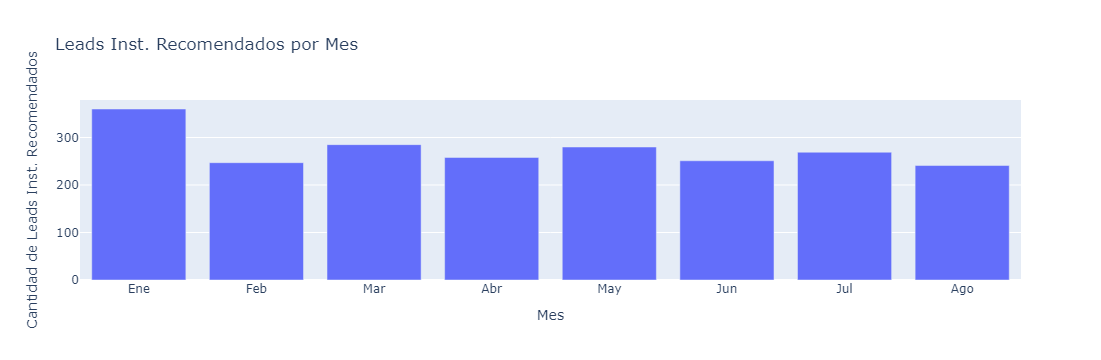

In [42]:
#import plotly.graph_objects as go
import plotly.express as px

# Agrupar por mes y ordenar por Mes_Num
df_grouped = df.groupby(['Mes', 'Mes_Num'])['Leads Inst. Recomendados'].sum().reset_index()
df_grouped = df_grouped.sort_values('Mes_Num')

# Crear el gráfico
fig = px.bar(df_grouped, x='Mes', y='leads_inst_recomendados',
             title='Leads Inst. Recomendados por Mes',
             labels={'leads_inst_recomendados': 'Cantidad de Leads Inst. Recomendados'})
fig.update_layout(xaxis_title='Mes', yaxis_title='Cantidad de Leads Inst. Recomendados')
fig.show()


## PRONÓSTICO

In [44]:
# Verifica si hay valores nulos después de la conversión
print(df_grouped['Mes'].isna().sum())

0


In [58]:
from sklearn.model_selection import train_test_split

# Crear una columna de características 'Fecha_num' para el modelo
df['Fecha_num'] = (df['Fecha'] - df['Fecha'].min()).dt.days

# Separar los datos para "Leads Inst. Recomendados" (ya que el archivo ahora maneja una sola columna de leads)
X = df[['Fecha_num']]  # Fecha en formato numérico
y = df['Leads Inst. Recomendados']  # Variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### REGRESIÓN LINEAL

Regresión Lineal - Leads Inst. Recomendados - MSE: 2547.3583187248933, MAE: 41.74020388658809, R^2: -635.8395796812233, MAPE: 0.16855750792443952


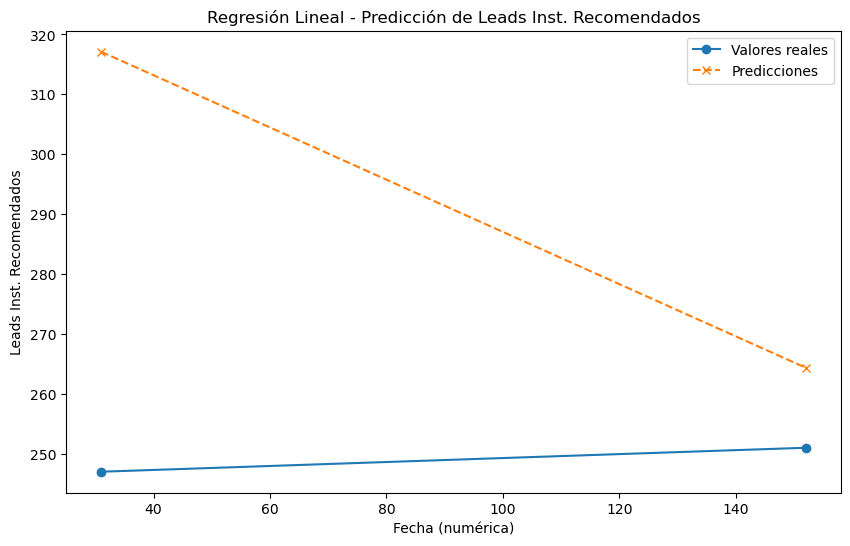

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Entrenar el modelo de regresión lineal para Leads Inst. Recomendados
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer pronósticos y evaluar
y_pred = model.predict(X_test)

# Calcular métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Mostrar resultados
print(f"Regresión Lineal - Leads Inst. Recomendados - MSE: {mse}, MAE: {mae}, R^2: {r2}, MAPE: {mape}")

# Visualización de resultados (opcional)
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_test, label='Valores reales', marker='o')
plt.plot(X_test, y_pred, label='Predicciones', linestyle='--', marker='x')
plt.xlabel('Fecha (numérica)')
plt.ylabel('Leads Inst. Recomendados')
plt.title('Regresión Lineal - Predicción de Leads Inst. Recomendados')
plt.legend()
plt.show()


### ARIMA

ARIMA - Leads Inst. Recomendados - MSE: 1248.67885102066, MAE: 26.77576482689899, R^2: 0.018804296471051862, MAPE: 0.09051438460610782


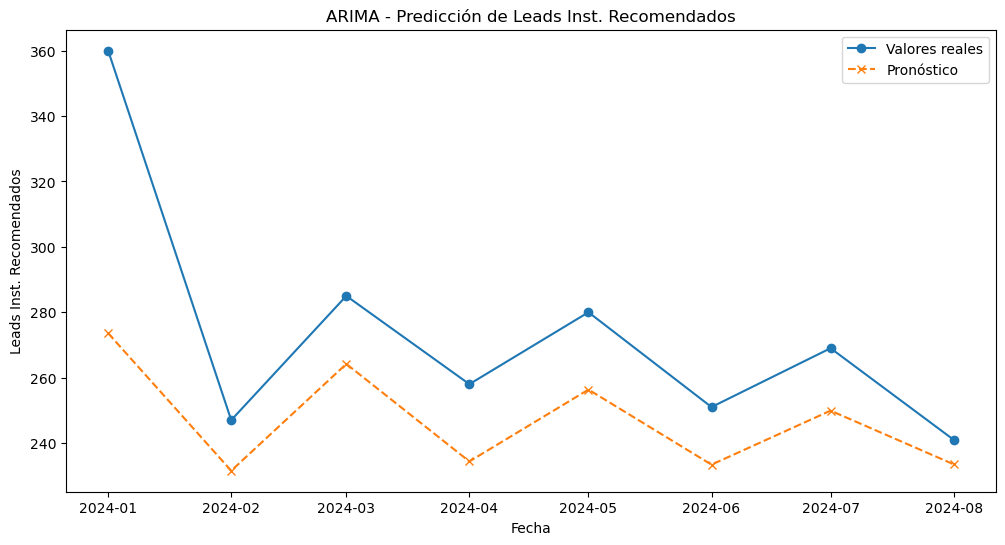

In [152]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

df = pd.DataFrame(data)

# Convertir la fecha a un formato numérico (días desde la fecha mínima)
df['Fecha_num'] = (df['Fecha'] - df['Fecha'].min()).dt.days

# Agrupar por mes para obtener los datos mensuales
df_grouped = df.groupby(df['Fecha'].dt.to_period('M')).agg({'Leads Inst. Recomendados': 'sum'}).reset_index()
df_grouped['Fecha'] = df_grouped['Fecha'].dt.to_timestamp()

# Asegurarse de que la columna 'Fecha' esté en formato datetime
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Fecha'])

# Establecer 'Fecha' como índice
df_grouped.set_index('Fecha', inplace=True)

# Crear la serie temporal para ARIMA
ts_leads = df_grouped['Leads Inst. Recomendados']

# Ajustar el modelo ARIMA
model_arima = ARIMA(ts_leads, order=(6, 1, 0))  # Ajusta el orden según sea necesario
fit_arima = model_arima.fit()

# Pronosticar y evaluar
forecast_arima = fit_arima.forecast(steps=len(ts_leads))
mse_arima = mean_squared_error(ts_leads, forecast_arima[:len(ts_leads)])
mae_arima = mean_absolute_error(ts_leads, forecast_arima[:len(ts_leads)])
r2_arima = r2_score(ts_leads, forecast_arima[:len(ts_leads)])
mape_arima = mean_absolute_percentage_error(ts_leads, forecast_arima[:len(ts_leads)])
print(f"ARIMA - Leads Inst. Recomendados - MSE: {mse_arima}, MAE: {mae_arima}, R^2: {r2_arima}, MAPE: {mape_arima}")

# Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(ts_leads, label='Valores reales', marker='o')
plt.plot(ts_leads.index, forecast_arima[:len(ts_leads)], label='Pronóstico', linestyle='--', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Leads Inst. Recomendados')
plt.title('ARIMA - Predicción de Leads Inst. Recomendados')
plt.legend()
plt.show()


### SARIMA

SARIMA - Leads Inst. Recomendados - MSE: 6445.632942500077, MAE: 67.37504499997749, R^2: -4.064895064520546, MAPE: 0.2394607183501779


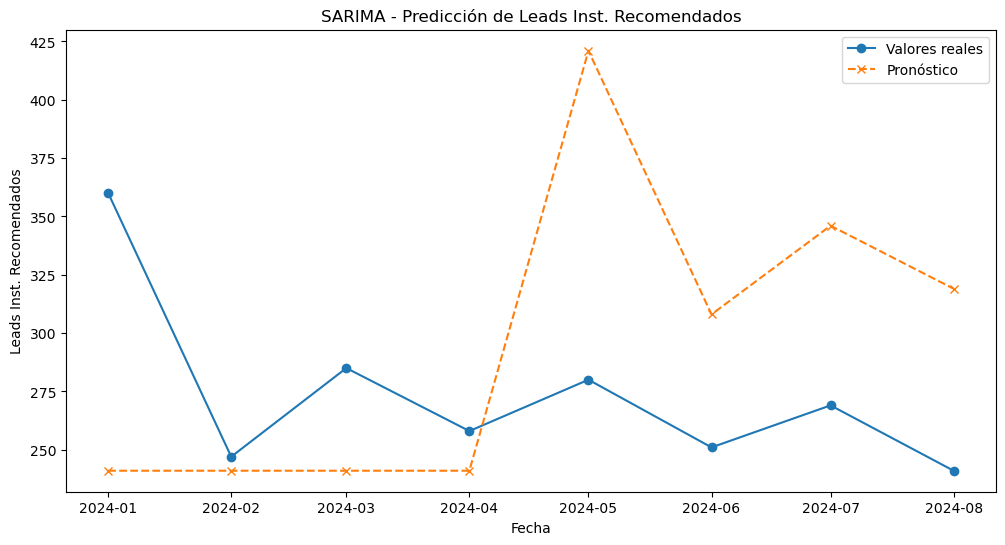

In [138]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

df = pd.DataFrame(data)

# Convertir la fecha a un formato numérico (días desde la fecha mínima)
df['Fecha_num'] = (df['Fecha'] - df['Fecha'].min()).dt.days

# Agrupar por mes para obtener los datos mensuales
df_grouped = df.groupby(df['Fecha'].dt.to_period('M')).agg({'Leads Inst. Recomendados': 'sum'}).reset_index()
df_grouped['Fecha'] = df_grouped['Fecha'].dt.to_timestamp()

# Asegurarse de que la columna 'Fecha' esté en formato datetime
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Fecha'])

# Establecer 'Fecha' como índice
df_grouped.set_index('Fecha', inplace=True)

# Crear la serie temporal para SARIMA
ts_sarima = df_grouped['Leads Inst. Recomendados']

# Ajustar el modelo SARIMA
model_sarima = SARIMAX(ts_sarima, 
                       order=(5, 1, 5),  # Parámetros ARIMA
                       seasonal_order=(1, 1, 1, 12))  # Parámetros estacionales
fit_sarima = model_sarima.fit(disp=False)

# Pronosticar y evaluar
forecast_sarima = fit_sarima.get_forecast(steps=len(ts_sarima)).predicted_mean
mse_sarima = mean_squared_error(ts_sarima, forecast_sarima[:len(ts_sarima)])
mae_sarima = mean_absolute_error(ts_sarima, forecast_sarima[:len(ts_sarima)])
r2_sarima = r2_score(ts_sarima, forecast_sarima[:len(ts_sarima)])
mape_sarima = mean_absolute_percentage_error(ts_sarima, forecast_sarima[:len(ts_sarima)])
print(f"SARIMA - Leads Inst. Recomendados - MSE: {mse_sarima}, MAE: {mae_sarima}, R^2: {r2_sarima}, MAPE: {mape_sarima}")

# Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(ts_sarima, label='Valores reales', marker='o')
plt.plot(ts_sarima.index, forecast_sarima[:len(ts_sarima)], label='Pronóstico', linestyle='--', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Leads Inst. Recomendados')
plt.title('SARIMA - Predicción de Leads Inst. Recomendados')
plt.legend()
plt.show()


### REGRESIÓN POLINÓMICA

Regresión Polinómica - MSE: 5385.9934950264915, MAE: 71.17413866976145, R^2: -1345.4983737566229, MAPE: 0.2864356465264781


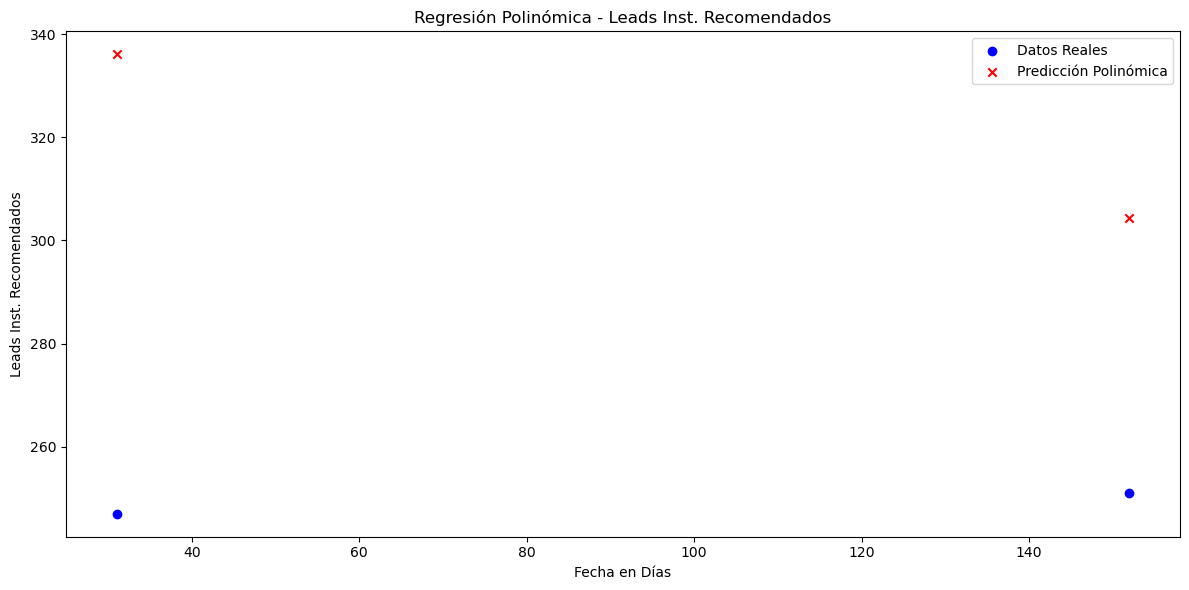

In [68]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

df = pd.DataFrame(data)

# Convertir la fecha a un formato numérico (días desde la fecha mínima)
df['Fecha_num'] = (df['Fecha'] - df['Fecha'].min()).dt.days

# Agrupar por mes para obtener los datos mensuales
df_grouped = df.groupby(df['Fecha'].dt.to_period('M')).agg({'Leads Inst. Recomendados': 'sum'}).reset_index()
df_grouped['Fecha'] = df_grouped['Fecha'].dt.to_timestamp()

# Asegurarse de que la columna 'Fecha' esté en formato datetime
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Fecha'])

# Crear la serie temporal para la regresión polinómica
df_grouped['Fecha_num'] = (df_grouped['Fecha'] - df_grouped['Fecha'].min()).dt.days
X = df_grouped[['Fecha_num']]
y = df_grouped['Leads Inst. Recomendados']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar la regresión polinómica
poly = PolynomialFeatures(degree=6)  # Ajusta el grado del polinomio si es necesario
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Hacer pronósticos y evaluar
y_pred = model_poly.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred)
mae_poly = mean_absolute_error(y_test, y_pred)
r2_poly = r2_score(y_test, y_pred)
mape_poly = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regresión Polinómica - MSE: {mse_poly}, MAE: {mae_poly}, R^2: {r2_poly}, MAPE: {mape_poly}")

# Opcional: Graficar los resultados para visualización
plt.figure(figsize=(12, 6))

plt.subplot(1, 1, 1)
plt.scatter(X_test, y_test, color='blue', label='Datos Reales')
plt.scatter(X_test, y_pred, color='red', label='Predicción Polinómica', marker='x')
plt.title('Regresión Polinómica - Leads Inst. Recomendados')
plt.xlabel('Fecha en Días')
plt.ylabel('Leads Inst. Recomendados')
plt.legend()

plt.tight_layout()
plt.show()


### REGRESIÓN LINEAL EXPONENCIAL

Modelo ETS - MSE: 887.1183666578853, MAE: 28.890472061601514, R^2: -3.5261141156014553, MAPE: 0.11207438592231109


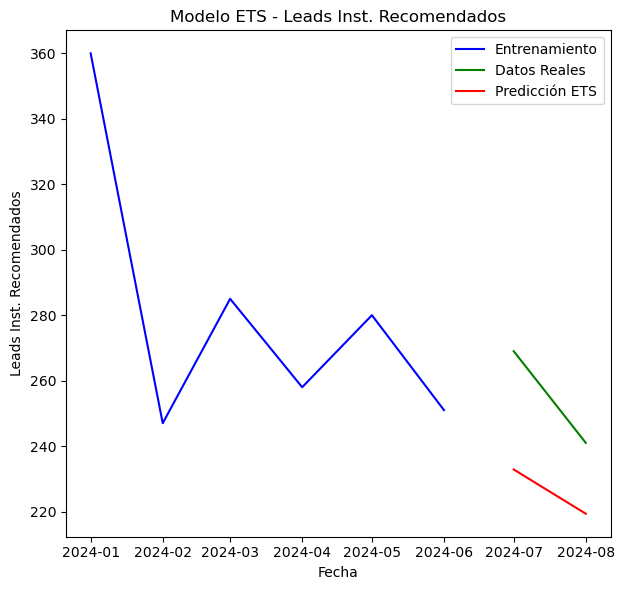

In [129]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

df = pd.DataFrame(data)

# Agrupar por mes para obtener los datos mensuales
df_grouped = df.groupby(df['Fecha'].dt.to_period('M')).agg({'Leads Inst. Recomendados': 'sum'}).reset_index()
df_grouped['Fecha'] = df_grouped['Fecha'].dt.to_timestamp()

# Asegurarse de que la columna 'Fecha' esté en formato datetime
df_grouped['Fecha'] = pd.to_datetime(df_grouped['Fecha'])

# Preparar los datos para la serie temporal
df_grouped.set_index('Fecha', inplace=True)

# Dividir en conjunto de entrenamiento y prueba
train_size = int(len(df_grouped) * 0.8)
train, test = df_grouped.iloc[:train_size], df_grouped.iloc[train_size:]

# Ajustar el modelo ETS sin estacionalidad
model_ets = ExponentialSmoothing(train['Leads Inst. Recomendados'], trend='add', seasonal=None)
fit_ets = model_ets.fit()

# Hacer predicciones sobre el conjunto de prueba
y_pred = fit_ets.forecast(steps=len(test))

# Evaluar el modelo
mse_ets = mean_squared_error(test['Leads Inst. Recomendados'], y_pred)
mae_ets = mean_absolute_error(test['Leads Inst. Recomendados'], y_pred)
r2_ets = r2_score(test['Leads Inst. Recomendados'], y_pred)
mape_ets = mean_absolute_percentage_error(test['Leads Inst. Recomendados'], y_pred)

print(f"Modelo ETS - MSE: {mse_ets}, MAE: {mae_ets}, R^2: {r2_ets}, MAPE: {mape_ets}")

# Opcional: Graficar los resultados para visualización
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train.index, train['Leads Inst. Recomendados'], label='Entrenamiento', color='blue')
plt.plot(test.index, test['Leads Inst. Recomendados'], label='Datos Reales', color='green')
plt.plot(test.index, y_pred, label='Predicción ETS', color='red')
plt.title('Modelo ETS - Leads Inst. Recomendados')
plt.xlabel('Fecha')
plt.ylabel('Leads Inst. Recomendados')
plt.legend()

plt.tight_layout()
plt.show()


## PROYECCIÓN

### ARIMA

Datos Proyectados con ARIMA:
        Fecha  Leads Inst. Recomendados
8  2024-09-30                273.585939
9  2024-10-31                231.525708
10 2024-11-30                264.197598
11 2024-12-31                234.361232


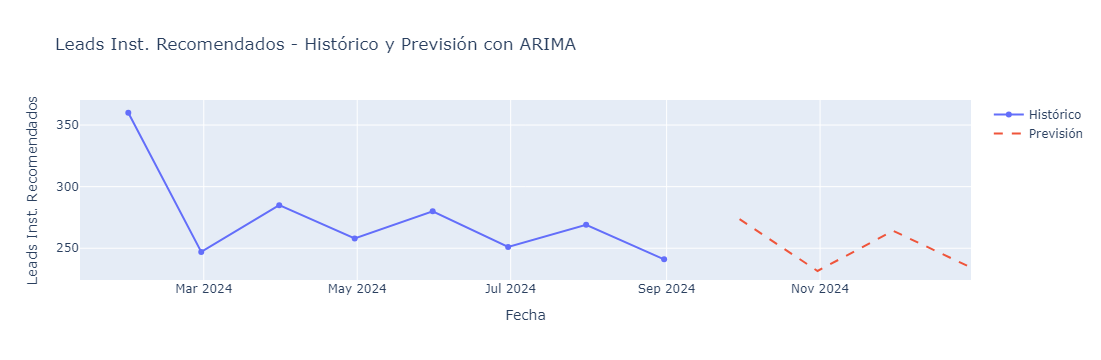

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import plotly.graph_objects as go
import warnings

# Suprimir todas las advertencias
warnings.filterwarnings('ignore')

# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

# Convertir la columna 'Fecha' a datetime si no lo está ya
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Agrupar los datos por mes (sin sumar columnas de fechas)
df_grouped = data.resample('M', on='Fecha').sum().reset_index()

# Definir el modelo ARIMA (orden 5,1,0 como ejemplo, puede ajustarse)
model = ARIMA(df_grouped['Leads Inst. Recomendados'], order=(6, 1, 0))  # Orden ajustable según los datos
model_fit = model.fit()

# Hacer previsiones hasta diciembre de 2024
forecast_steps = (pd.to_datetime('2024-12-31') - df_grouped['Fecha'].max()).days // 30
forecast = model_fit.forecast(steps=forecast_steps)

# Crear un DataFrame para la previsión
forecast_dates = pd.date_range(df_grouped['Fecha'].max() + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({'Fecha': forecast_dates, 'Leads Inst. Recomendados': forecast})

# Combinar los datos históricos con las previsiones
combined_df = pd.concat([df_grouped[['Fecha', 'Leads Inst. Recomendados']], forecast_df])

# Imprimir los datos proyectados
print("Datos Proyectados con ARIMA:")
print(forecast_df)

# Crear el gráfico dinámico con Plotly
fig = go.Figure()

# Añadir datos históricos
fig.add_trace(go.Scatter(x=df_grouped['Fecha'], y=df_grouped['Leads Inst. Recomendados'],
                         mode='lines+markers', name='Histórico'))

# Añadir previsión
fig.add_trace(go.Scatter(x=forecast_df['Fecha'], y=forecast_df['Leads Inst. Recomendados'],
                         mode='lines', name='Previsión', line=dict(dash='dash')))

# Configurar el layout del gráfico
fig.update_layout(title='Leads Inst. Recomendados - Histórico y Previsión con ARIMA',
                  xaxis_title='Fecha',
                  yaxis_title='Leads Inst. Recomendados')

# Mostrar el gráfico
fig.show()


### REGRESION LINEAL

Proyecciones de Leads Inst. Recomendados con Regresión Lineal:
Sep: 230.86
Oct: 221.30
Nov: 211.74
Dic: 202.18


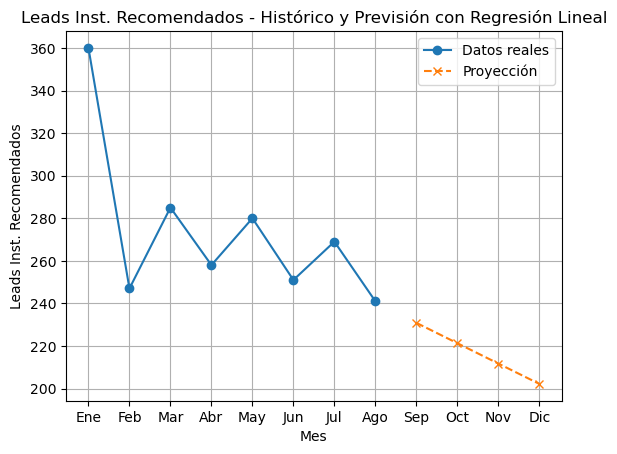

In [117]:
# Importar librerías
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Datos iniciales (del 2024)
# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

# Crear el DataFrame
df = pd.DataFrame(data)

# Convertir los meses a números para el modelo
df['Fecha'] = np.arange(1, len(df)+1)

# Definir X (Meses) y y (Leads Inst. Recomendados)
X = df[['Fecha']]
y = df['Leads Inst. Recomendados']

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X, y)

# Proyectar para los meses de septiembre a diciembre (Mes 9 a Mes 12)
futuro = pd.DataFrame({'Fecha': [9, 10, 11, 12]})
proyecciones = model.predict(futuro)

# Mostrar resultados
print("Proyecciones de Leads Inst. Recomendados con Regresión Lineal:")
for mes, proyeccion in zip(['Sep', 'Oct', 'Nov', 'Dic'], proyecciones):
    print(f"{mes}: {proyeccion:.2f}")

# Graficar los resultados
plt.plot(df['Fecha'], df['Leads Inst. Recomendados'], label='Datos reales', marker='o')
plt.plot(futuro['Fecha'], proyecciones, label='Proyección', marker='x', linestyle='--')
plt.xticks(np.arange(1, 13), ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.xlabel('Mes')
plt.ylabel('Leads Inst. Recomendados')
plt.title('Leads Inst. Recomendados - Histórico y Previsión con Regresión Lineal')
plt.legend()
plt.grid(True)
plt.show()


### Regresión lineal exponencial suavizada (ETS)

Proyecciones de Leads Inst. Recomendados con ETS:
        Fecha  Leads Inst. Recomendados
8  2024-09-30                230.857143
9  2024-10-31                221.297619
10 2024-11-30                211.738095
11 2024-12-31                202.178571


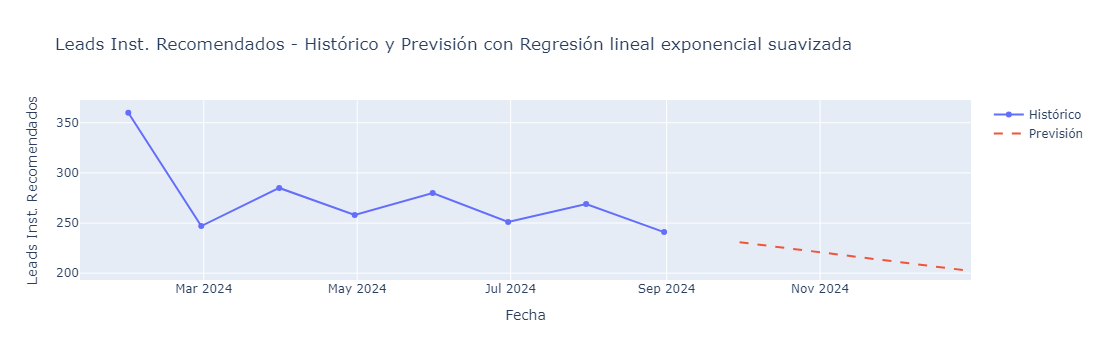

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.graph_objects as go
import warnings

# Suprimir todas las advertencias
warnings.filterwarnings('ignore')

# Leer el archivo Excel
data = pd.read_excel('Lead Instalaciones.xlsx', sheet_name='Hoja1')

# Convertir la columna 'Fecha' a datetime si no lo está ya
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Agrupar los datos por mes (sin sumar columnas de fechas)
df_grouped = data.resample('M', on='Fecha').sum().reset_index()

# Definir el modelo ETS sin estacionalidad debido a los pocos datos
model = ExponentialSmoothing(df_grouped['Leads Inst. Recomendados'],
                             trend='add', seasonal=None)  # Estacionalidad desactivada
model_fit = model.fit()

# Hacer previsiones hasta diciembre de 2024
forecast_steps = (pd.to_datetime('2024-12-31') - df_grouped['Fecha'].max()).days // 30
forecast = model_fit.forecast(forecast_steps)

# Crear un DataFrame para la previsión
forecast_dates = pd.date_range(df_grouped['Fecha'].max() + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame({'Fecha': forecast_dates, 'Leads Inst. Recomendados': forecast})

# Combinar los datos históricos con las previsiones
combined_df = pd.concat([df_grouped[['Fecha', 'Leads Inst. Recomendados']], forecast_df])

# Imprimir los datos proyectados
print("Proyecciones de Leads Inst. Recomendados con ETS:")
print(forecast_df)

# Crear el gráfico dinámico con Plotly
fig = go.Figure()

# Añadir datos históricos
fig.add_trace(go.Scatter(x=df_grouped['Fecha'], y=df_grouped['Leads Inst. Recomendados'],
                         mode='lines+markers', name='Histórico'))

# Añadir previsión
fig.add_trace(go.Scatter(x=forecast_df['Fecha'], y=forecast_df['Leads Inst. Recomendados'],
                         mode='lines', name='Previsión', line=dict(dash='dash')))

# Configurar el layout del gráfico
fig.update_layout(title='Leads Inst. Recomendados - Histórico y Previsión con Regresión lineal exponencial suavizada',
                  xaxis_title='Fecha',
                  yaxis_title='Leads Inst. Recomendados')

# Mostrar el gráfico
fig.show()
